# Example 3: Transforming Data
This notebook demonstrates PyThermoNDT's transform system in two parts:

**1) PyThermoNDT transforms** - Core transform building blocks:
- 1.1) Single transform: ApplyLUT
- 1.2) Transform pipeline: spatial (ApplyLUT → SubtractFrame → MinMaxNormalize)
- 1.3) Transform pipeline: frequency domain (ApplyLUT → PulsePhaseThermography → ExtractPhase)
- 1.4) Writing your own transforms

**2) Applying transforms to datasets** - Attaching transforms to data sources:
- 2.1) Single reader with transform
- 2.2) Combining multiple readers
- 2.3) Indexing datasets and chaining transforms

First we import the necessary modules and create reader objects so we have a datasource.

**Note:** In this example we use both data stored on the local file system and data stored in S3 an S3 Bucket. By setting the option `download_files` to True, pythermondt will download the data from S3 to the local file system in a folder called '.pythermondt_cache'. As result subsequent calls to the same file will be much faster. The cache can be deleted by simply removing the folder. The default location for this folder is in the current working directory. Override that directory by setting the environment variable `PYTHERMONDT_DOWNLOAD_DIR` (or putting `pythermondt_download_dir=/your/path` in the `.env file`), and pythermondt will pick it up automatically.

In [18]:
import pythermondt.transforms as T
from pythermondt import IndexedThermoDataset, LocalReader, S3Reader, ThermoDataset

# Create data sources
localreader = LocalReader(pattern="./example_data", recursive=True)
s3reader = S3Reader(bucket="ffg-bp", prefix="example2_writing_data", download_files=True)

## 1) PyThermoNDT transforms
Core transforms are provided in the `pythermondt.transforms` module. These transforms can be used to preprocess data before training a model or to extract features from the data.

### 1.1) Single transform: ApplyLUT
Use a single transform to convert raw UINT16 temperature data to float values using the lookup table stored in the container. After ApplyLUT the `/Data/Tdata` unit changes from arbitrary to kelvin.

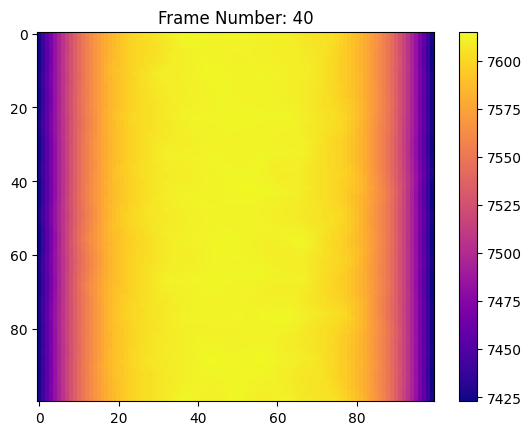

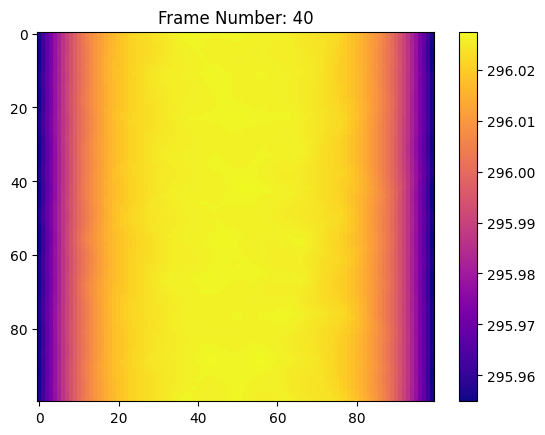

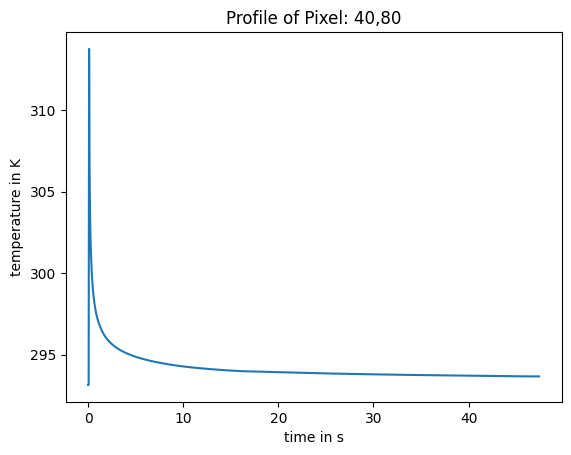

In [19]:
# Setup
container = localreader[2]
transform = T.ApplyLUT()

container.show_frame(40)

container = transform(container)

container.show_frame(40)
container.show_pixel_profile(40,80)

### 1.2) Transform pipeline: spatial
Compose multiple deterministic transforms to clean and scale the sequence:
- Convert to kelvin (ApplyLUT)
- Remove the initial flash frame as a baseline (SubtractFrame)
- Normalize to [0, 1] (MinMaxNormalize), which makes the temperature values dimensionless

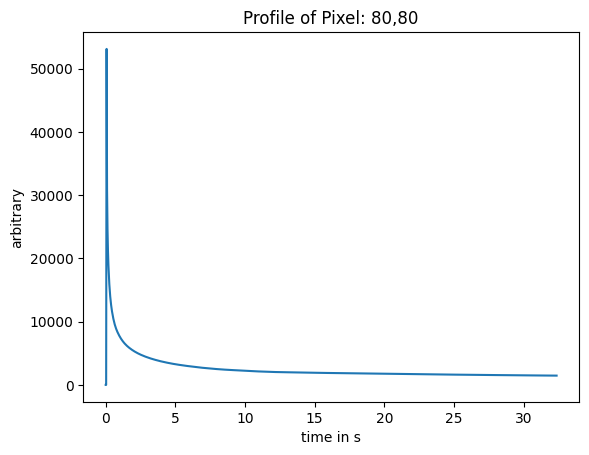

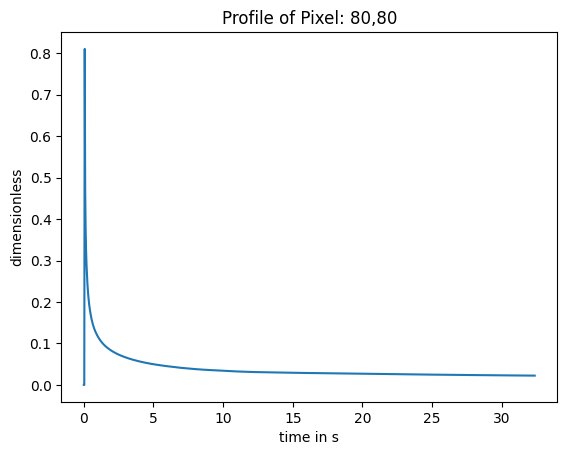

In [20]:
container = localreader[0]
spatial_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(frame=0),
    T.MinMaxNormalize(),
])

container.show_pixel_profile(80, 80)

container = spatial_pipeline(container) 

container.show_pixel_profile(80, 80)

### 1.3) Transform pipeline: frequency domain
PulsePhaseThermography (PPT) moves the sequence from time to frequency domain using an FFT. Requirements and behavior:
- `/MetaData/DomainValues` must be time and uniformly spaced
- Full spectrum is kept (no `freq_indices`), so all frequency bins are available
- DomainValues are replaced with frequencies in hertz
- The FFT produces complex data; ExtractPhase converts to real phase images (radians) for visualization

Defect before PPT:


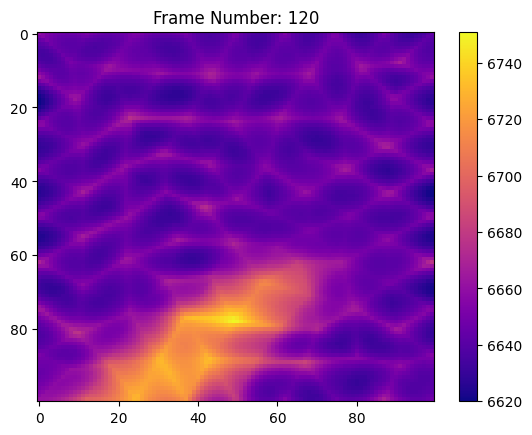

First 6 frequency bins (Hz): tensor([0.0000, 0.2625, 0.5250, 0.7875, 1.0501, 1.3126])
Phase image at first frequency bin after PPT:


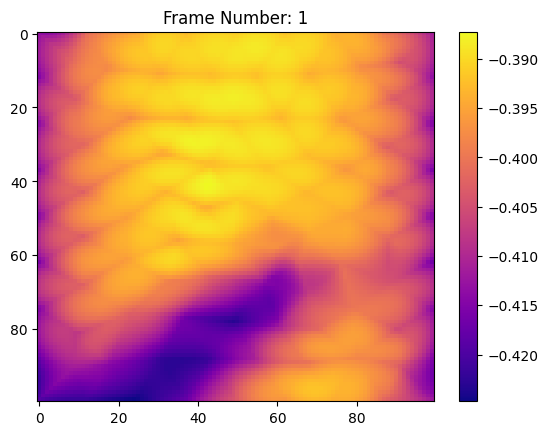

In [21]:
# 2.2) Frequency pipeline: ApplyLUT → PulsePhaseThermography (full spectrum) → ExtractPhase
container = localreader[1]
ppt_pipeline = T.Compose([
    T.ApplyLUT(),
    T.PulsePhaseThermography(),  # full spectrum FFT (keeps all frequency bins)
    T.ExtractPhase(),            # unwraps by default and yields phase images in radians
])

print("Defect before PPT:")
container.show_frame(120)
container = ppt_pipeline(container)
print("First 6 frequency bins (Hz):", container.get_dataset("/MetaData/DomainValues")[:6])
print("Phase image at first frequency bin after PPT:")
container.show_frame(1)

### 1.4) Writing your own transforms
Custom transforms follow the pattern: read datasets, validate units/shape, operate, then update datasets and units. This example converts time domain values from seconds to milliseconds using `ConvertToMilliseconds` and runs directly on a container loaded from the reader (no dataset dependency).

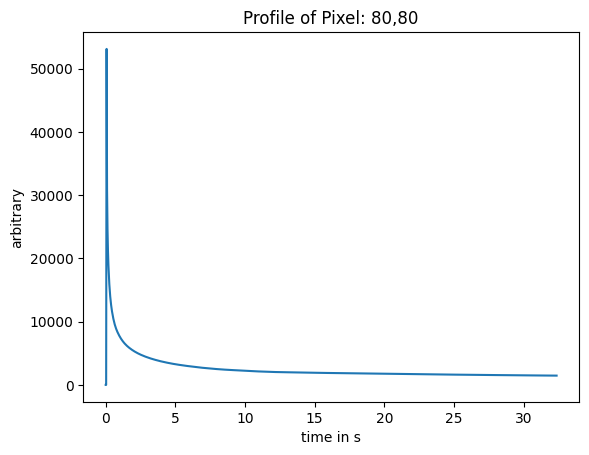

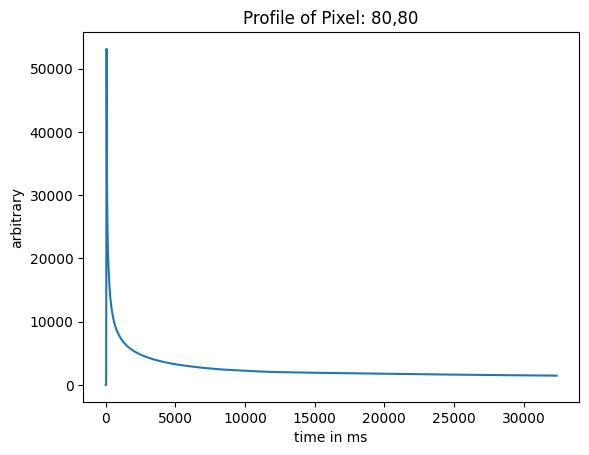

In [22]:
from pythermondt.data import DataContainer
from pythermondt.transforms import ThermoTransform
from pythermondt.data import units

# Define a custom transform
class ConvertToMilliseconds(ThermoTransform):
    def forward(self, container: DataContainer) -> DataContainer:
        # Get data from the container
        domain_values = container.get_dataset("/MetaData/DomainValues")
        domain_unit = container.get_unit("/MetaData/DomainValues")

        # Update container
        if domain_unit == units.second:
            container.update_dataset("/MetaData/DomainValues", domain_values * 1000)
            container.update_unit("/MetaData/DomainValues", units.millisecond)

        # Return container
        return container

# Create a new instance of the custom transform 
myowntransform = ConvertToMilliseconds()

# Apply the custom transform on a single container
container = localreader[0]
container.show_pixel_profile(80, 80)

container = myowntransform(container) 

container.show_pixel_profile(80, 80)

## 2) Applying transforms to datasets
`ThermoDataset` wraps readers and applies transforms automatically to each container at access time. This enables efficient data pipelines: transforms are computed lazily on-the-fly rather than preprocessing everything upfront. You can combine multiple readers into one dataset and apply the same transform chain to all of them.

### 2.1) Single reader with transform
Start with a single reader and attach the spatial_pipeline transform. The dataset applies the transform chain to each container when accessed. Use `get_transform_chain()` to inspect the pipeline.

ThermoDataset chain:
Compose([
    ApplyLUT() [Deterministic],
    SubtractFrame(frame=0) [Deterministic],
    MinMaxNormalize(eps=1e-12) [Deterministic]
])
Number of files in the dataset: 3


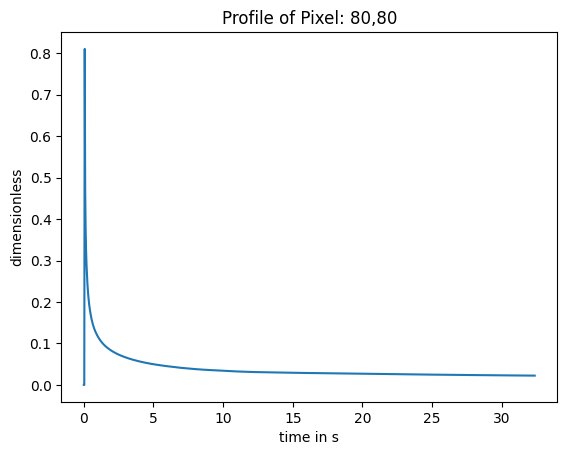

In [23]:
dataset = ThermoDataset(data_source=localreader, transform=spatial_pipeline)
print("ThermoDataset chain:")
print(dataset.get_transform_chain())
print(f"Number of files in the dataset: {len(dataset)}")
dataset[0].show_pixel_profile(80, 80)

### 2.2) Combining multiple readers
Extend the dataset by passing a list of readers instead of a single reader. The dataset aggregates all files and applies the same transform chain to data from both sources. 

**Note** Call `multi_dataset.download()` before training to prefetch remote files locally.

Number of files in the localreader:  3
Number of files in the s3reader:  3
Number of files in the multi_dataset:  6


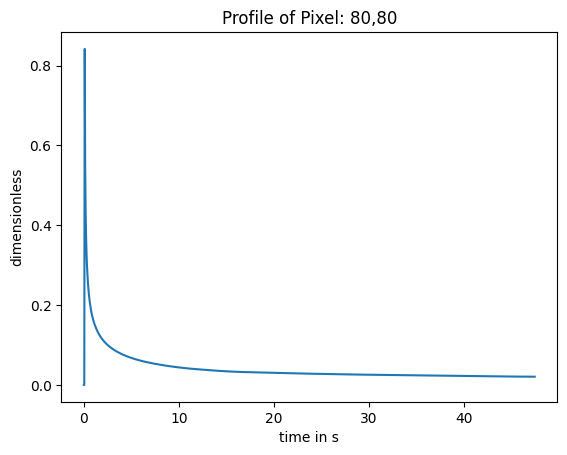

In [24]:
multi_dataset = ThermoDataset(data_source=[localreader, s3reader], transform=spatial_pipeline)
multi_dataset.download()  # Pre-fetch remote files locally
print("Number of files in the localreader: ", len(localreader))
print("Number of files in the s3reader: ", len(s3reader))
print("Number of files in the multi_dataset: ", len(multi_dataset))
multi_dataset[5].show_pixel_profile(80, 80)

### 2.3) Indexing datasets and chaining transforms
`IndexedThermoDataset` is a lightweight view on a parent dataset: it selects a subset of indices without extra I/O or copies, and can add its own transforms on top of the parent's chain. This is useful for train/val/test splits or experiment-specific preprocessing while reusing the same base data and cache.

Transforms stack automatically. The parent dataset chain runs first; the indexed dataset appends its transform. Use `get_transform_chain()` to inspect the effective sequence.

ThermoDataset chain:
Compose([
    ApplyLUT() [Deterministic],
    SubtractFrame(frame=0) [Deterministic],
    MinMaxNormalize(eps=1e-12) [Deterministic]
])

IndexedThermoDataset chain (appends ConvertToMilliseconds):
Compose([
    ApplyLUT() [Deterministic],
    SubtractFrame(frame=0) [Deterministic],
    MinMaxNormalize(eps=1e-12) [Deterministic],
    ConvertToMilliseconds() [Deterministic]
])


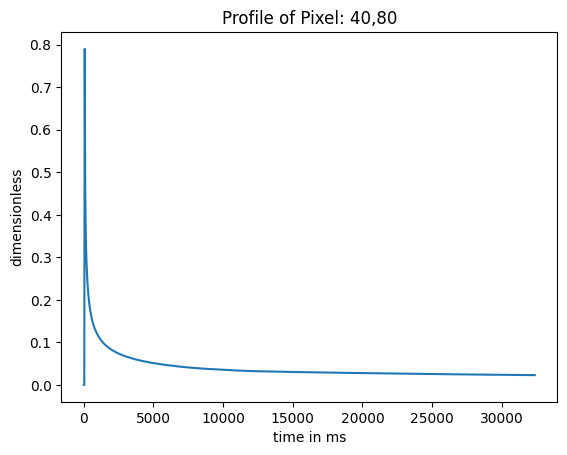

In [25]:
# Inspect and extend transform chains
print("ThermoDataset chain:")
print(dataset.get_transform_chain())

indexed = IndexedThermoDataset(multi_dataset, indices=[0, 1, 2], transform=ConvertToMilliseconds())
print("\nIndexedThermoDataset chain (appends ConvertToMilliseconds):")
print(indexed.get_transform_chain())

sample = indexed[0]
sample.show_pixel_profile(40, 80)